# Imports

In [15]:
import functions as f  # Our defined functions
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

import importlib
importlib.reload(f)

GRatio = (1 + 5 ** (1/2)) / 2

WIDTH = .5
DASH = (10, 10)


# Solving models

Model verified.


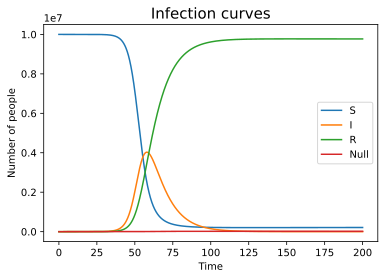

Pop variation: -18564


In [16]:
SIR_deaths = f.loadModel('SIR_deaths')
solution, t_span = f.solve(SIR_deaths, (0, 200), 100)

fig = plt.figure()
f.plotCurves(t_span,
             np.transpose(solution),
             toPlot=list(range(solution.shape[1])),
             labels=f.getCompartments(SIR_deaths))
plt.show()

print(f"Pop variation: {f.getPopChange(SIR_deaths, solution):.0f}")


In [17]:
modelName = 'SIRS_deaths'

model = f.loadModel(modelName)
solution, t_span = f.solve(model, (0, 200), 100)

# SIRS_deaths2 = f.mod(SIRS_deaths)
# solution2, t_span2 = f.solve(SIRS_deaths2, (0, 200), 100)

fig = plt.figure()
f.plotCurves(t_span,
             np.transpose(solution),
             toPlot=list(range(solution.shape[1])),
             labels=f.getCompartments(model))
plt.show()

popChange = - solution[-1, f.getCompartments(model).index('Null')]
print(f"Pop variation: {popChange:.0f}")

model, modelMod, r0 = f.computeR0(modelName, (0, 100), 10)

print(r0)


Model verified.


TypeError: string indices must be integers


Computation of Rt
Model verified.
Creating new model!
New model created in 0.0e+00 seconds.
Véfication faite, les deux modèles sont identiques.


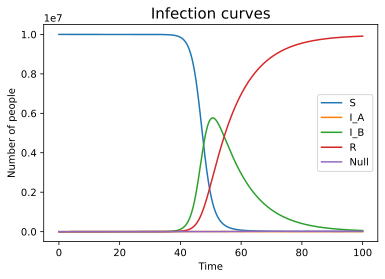

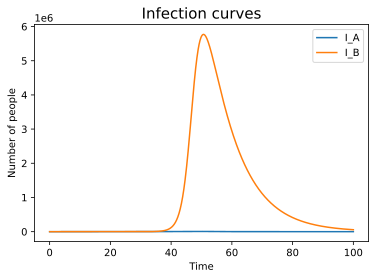

Creating new model!
1.0 1.0
1.158407560123116 0.8726318348282013
Time difference: 0.0


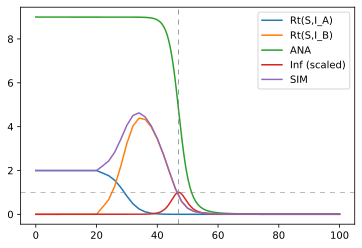

Pop variation: -18811


In [ ]:
model, newModel, solution, t_span, values = f.computeRt('SIR_vars', (0, 100), sub_rt=1/2)

fig = plt.figure()
f.plotCurves(t_span,
             np.transpose(solution),
             toPlot=list(range(solution.shape[1])),
             labels=f.getCompartments(model))
plt.show()

fig = plt.figure()
f.plotCurves(t_span,
             np.transpose(solution),
             toPlot=[1, 2],
             labels=f.getCompartments(model))
plt.show()

fig = plt.figure()

infsScaled = f.infsScaled(model, solution)
rt_times = np.array([key for key in values])
rt = np.zeros_like(rt_times, dtype='float64')
for rtNode in f.getRtNodes(f.mod(model, False, False)):
    rt_rtNode = np.array([values[key][rtNode] for key in values])
    plt.plot(rt_times, rt_rtNode, label=rtNode)
    rt += rt_rtNode
rt_ANA = 9 * solution[:, 0] / np.array([f.popTot(model, x) for x in solution])

idx_infs = f.find_intersection(infsScaled, 1)
xTimeInfs = (t_span[idx_infs[0]] + t_span[idx_infs[1]]) / 2
idx_rt = f.find_intersection(rt, 1)
xTimeRt = (rt_times[idx_rt[0]] + rt_times[idx_rt[1]]) / 2

print(f'Time difference: {np.abs(xTimeInfs - xTimeRt)}')

plt.plot(t_span, rt_ANA, label='ANA')
plt.plot(t_span, infsScaled, label='Inf (scaled)')
plt.plot(rt_times, rt, label='SIM')
plt.axhline(y=1, linestyle='--', color='grey', linewidth=WIDTH, dashes=DASH)
plt.axvline(x=xTimeInfs, linestyle='--', color='grey',
            linewidth=WIDTH, dashes=DASH)
plt.axvline(x=xTimeRt, linestyle='--', color='grey',
            linewidth=WIDTH, dashes=DASH)
plt.legend(loc='best')
plt.show()

fig.savefig('plot.pdf', bbox_inches='tight')

# printFlows(SIRvars)

popChange = - solution[-1, f.getCompartments(model).index('Null')]
print(f"Pop variation: {popChange:.0f}")


In [ ]:
SIS, SISmod, R0 = f.computeR0("SIS", write=True, overWrite=True)
f.printModel(R0)


Computation of Rt
Model verified.
Creating new model!
New model created in 0.0e+00 seconds.
Writing new model to file SIS_mod.json.
{
  "Rt(S,I)": 3.98
}
